In [1]:
#import datetime as dt
#from datetime import date
#import os
#import sys
import numpy as np
import pandas as pd
#from glob import glob
#import sqlalchemy
#import pymysql
#import time, datetime
#from datetime import datetime, timedelta
#from datetime import timedelta, date
#import time
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#pd.set_option('display.max_columns', 500)
#import warnings
#warnings.filterwarnings("ignore")
from scipy.stats import kurtosis
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt,het_white
from statsmodels.stats.diagnostic import linear_harvey_collier, linear_reset, spec_white
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor


In [2]:
#Importando as bases
from numpy import unicode_

base = pd.read_csv(r'../NPS_Bulky/analise_dummy_ou_outros (version 1).csv',sep=';', encoding='ISO-8859-1')
base.shape

C:\Users\marcus.boas\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3378: DtypeWarning: Columns (90,91,96,98,99,101,102) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(24575, 212)

In [3]:
#Cria as colunas de soma das dummys
def somase(data_frame):

    colunas = ['Flag Atraso Transporte2','Flag Atraso Fornecedor3','Flag Atraso Coleta4','Flag Atraso Cliente5','[FLAG]Cancelado',
    '[FLAG]Recompra_ff','[FLAG]Erro prazo transporte validacao','[FLAG]Cross','[FLAG]Atraso_criacao_OC','[FLAG]Reprogramacao_OC',
    '[FLAG]Atraso Fornecedor','[FLAG] Entregue','[FLAG] Pratica_indevida','[FLAG] Sac_pos_entrega','[FLAG] Reversa','[FLAG] PJ',
    '[FLAG] Mais de uma entrega','[FLAG]Importacao WMS','[FLAG] Recompra','[FLAG] Entrega_Mista','[FLAG] Virada_Faturamento',
    'FLAG - Infos_encontradas','[FLAG] Atraso limite','[FLAG] Oc sem bip','[FLAG] Insucesso','[FLAG] End. N.Localizado/Ausente',
    '[FLAG] Tempo Habil','[FLAG] Atraso Redespacho','[FLAG] Diarias','[FLAG] Atraso Coletas','[FLAG] Leves','[FLAG] Atraso CD',
    '[FLAG] Recompra assistencia','[FLAG] Recompra Total','[FLAG] Origem Recompra','[FLAG] Atraso Cliente*','FLAG_Parceiro',
    'FLAG_terceiras_parceiras','[FLAG] - Detrator_mais_entrega','[FLAG] - Categorias_detrator','[FLAG] Private_Label','Guide_flag'
                ]
   
    df_retorno = data_frame
    for coluna in colunas:
        try:
            nova_coluna = df_retorno.groupby('pv_pai')[coluna].sum()
            df_retorno = df_retorno.merge(nova_coluna, left_on='pv_pai', right_on='pv_pai',how='left')
            df_retorno.rename(columns={coluna + '_y': coluna + '_soma'}, inplace=True,errors='raise')
            # print('realizado colunas: ', coluna + '_soma')
        except Exception as e:
            print('deu ruim: ', e)
    return df_retorno
    
#Roda a função somase com a base importada
base = somase(base)

In [4]:
#Cria as colunas de detrator, neutro e promotor
def dummy_detra(resposta):
    if resposta <= 6:
        return "1"
    else:
        return "0"

def neutro(resposta):
    if resposta >= 7 and resposta <= 8:
        return "1"
    else:
        return "0"

def promotor (resposta):
    if resposta >= 9:
        return '1'
    else:
        return '0'

base['detrator'] = base.apply(
        lambda row: dummy_detra(row['customer_answer']), axis=1)

base['neutro'] = base.apply(
lambda row: neutro(row['customer_answer']), axis=1)

base['promotor'] = base.apply(
        lambda row: promotor(row['customer_answer']), axis=1)

In [5]:
#Drop colunas desnecessárias
base = base.drop(columns=['3. Sac_pos_entrega_s','97 Atraso WMS_s','96 Recompra_s','Reclamacao_cliente_s','Info_Encontradas_s','Coluna34','Coluna4',
'Coluna2','cidade_cliente','pedped','cep','chave_nfm','chave_ped','nf_fornecedor','fornecedor','nf_mi','data_compra_cliente','sku',
'categoria_old','categoria_new','head_categoria','descricao','chave_pedped','pedido_x','origem','destino','tp_t3','data_criacao_oc',
'data_aprovacao','data_limite_fornecedor','data_expedicao','data_limite_cliente','data_limite_coleta','data_limite_transporte','data_bip',
'data_entregue','pz_total_x','nota_nfd','tp_nf','tp_eagle','status_pedido_portal','Atraso Local V1','OC','Motivo_Recompra','prazo_interno_x',
'prazo_interno_y','channel','Virada_FF_VAO','Pesso Juridica','pedido_prazo_fornecedor','pedido_prazo_transportadora','cotacao_prazo_transporte',
'cotacao_prazo_fornecedor','Título Romaneio','Motorista','Roteiro','Prioridade','Codigo_EDI','EDI','Importacao_FF','Atraso Local V2',
'92.Virada_ff_Vao','91.Erro de Prazo Transporte','89.Reversa','1. Depara Transportadora','2. Pratica_indevida','3. Sac_pos_entrega',
'97 Atraso WMS','96 Recompra','Consolidador','Data_resposta','Media_dia_x_resposta','Motivo_sac Entrega','Reclamacao_cliente','chave_TP',
'DePara_TP_Parceiro:','Rank_Regras','[Prazo] aux','Dia Sem. Aprovação','Feriado','Prazo Vendido','Delta prazo cotado',
'Data Limite Cotado','aux Comparação Prazo Total (Cotado x Vendido)','Aux_coleta','Prazo_interno','Prazo_x_exp','CEP2','Pedido_original_Recompra',
'Data_Limite_para_Recompra','nova_data_limite','Aging_cliente','data-entrega','Chave_espaco_2','Fornecedor_ocr_desc',
'Guide','Categoria_nova_estrutura','Cabe_casa',
'Yes_casa','% detrator_categorias','qtd. categoria_detrator','1 cat','2 cat','3 cat','4 cat','5 cat','Loja',
'[compra] Foi fácil realizar sua compra?','Estado_destino_sigla','Semana','Mês',
'[pagamento] Como foi a sua experiência com relação ao pagamento do produto adquirido?','Como foi sua experiência enquanto esperava o seu produto?','[entrega] Você ficou satisfeito(a) com a entrega?',
'[produto] O produto atendeu às suas expectativas?','[atendimento] Você ficou satisfeito com nosso atendimento?','[entrega]] A embalagem chegou com problemas (rasgada, danificada, molhada...)',
'[entrega]] A entrega foi feita fora do prazo','[[entrega]] Achei o prazo de entrega muito longo.]',
'[[entrega]] Achei o valor do frete muito alto.]','[[entrega]] Não foi possível agendar a entrega.]',
'[atendimento]] (aberta) Outro. Por favor, especifique:]','(aberta) Como foi sua experiência enquanto esperava o seu produto?',
'[compra]] (aberta) Foi fácil realizar sua compra?]','[entrega]] (aberta) Por favor, nos conte mais sobre a sua experiência.',
'[entrega]] (aberta) Você ficou satisfeito(a) com a entrega?','[pagamento]] (aberta) Visando melhorar essa experiência, você pode contar quais d',
'[produto]] (aberta) Por favor, nos conte mais sobre a sua resposta','Atraso_Transp_s','Flag Atraso Fornecedor_s','Flag Atraso Coleta_s','Flag Atraso Cliente_s',
'[FLAG]Cancelado_S','[FLAG]Recompra_ff_S','[FLAG]Erro prazo transporte validacao_S','96.Atraso_importação_WMS_S',
'[FLAG]Cross_S','[FLAG]Atraso_criacao_OC_S','[FLAG]Reprogramacao_OC_S','92.Virada_ff_Vao_S','91.Erro de Prazo Transporte_S',
'[FLAG]Atraso Fornecedor_S','89.Reversa_S','NPS_NOTA_S','[FLAG] Entregue_S','[FLAG] Pratica_indevida_s','[FLAG] Sac_pos_entrega_s',
'[FLAG] Reversa_s','[FLAG] PJ_s','[FLAG] Mais de uma entrega_s','[FLAG]Importacao WMS_s','[FLAG] Recompra_s',
'[FLAG] Entrega_Mista_s','[FLAG] Virada_Faturamento_s','FLAG - Infos_encontradas_s','[FLAG] Atraso limite_s',
'[FLAG] Oc sem bip_s','[FLAG] Insucesso_s','[FLAG] End. N.Localizado/Ausente_s','[FLAG] Tempo Habil_s',
'[FLAG] Atraso Redespacho_s','[FLAG] Diarias_s','Flag Atraso Transporte2_x','Flag Atraso Fornecedor3_x',
'Flag Atraso Coleta4_x','Flag Atraso Cliente5_x','[FLAG]Cancelado_x','[FLAG]Recompra_ff_x','[FLAG]Erro prazo transporte validacao_x',
'96.Atraso_importação_WMS','[FLAG]Cross_x','[FLAG]Atraso_criacao_OC_x','[FLAG]Reprogramacao_OC_x','[FLAG]Atraso Fornecedor_x','NPS_NOTA',
'[FLAG] Entregue_x','[FLAG] Pratica_indevida_x','[FLAG] Sac_pos_entrega_x','[FLAG] Reversa_x','[FLAG] PJ_x','[FLAG] Mais de uma entrega_x',
'[FLAG]Importacao WMS_x','[FLAG] Recompra_x','[FLAG] Entrega_Mista_x','[FLAG] Virada_Faturamento_x','Info_Encontradas',
'FLAG - Infos_encontradas_x','[FLAG] Atraso limite_x','[FLAG] Oc sem bip_x','[FLAG] Insucesso_x',
'[FLAG] End. N.Localizado/Ausente_x','[FLAG] Tempo Habil_x','[FLAG] Atraso Redespacho_x',
'[FLAG] Diarias_x','[FLAG] Atraso Coletas_x','[FLAG] Leves_x','[FLAG] Atraso CD_x','[FLAG] Recompra assistencia_x',
'[FLAG] Recompra Total_x','[FLAG] Origem Recompra_x','[FLAG] Atraso Cliente*_x','FLAG_Parceiro_x','FLAG_terceiras_parceiras_x',
'[FLAG] - Detrator_mais_entrega_x','[FLAG] - Categorias_detrator_x','[FLAG] Private_Label_x','Guide_flag_x',
'[FLAG] Origem Recompra_soma',
'FLAG_terceiras_parceiras_soma',
'Guide_flag_soma','tipo_venda','[FLAG] Entregue_soma', 'created_at','tipo_pedido_nps','[FLAG]Cancelado_soma','[FLAG]Recompra_ff_soma','[FLAG] PJ_soma','FLAG - Infos_encontradas_soma','[FLAG] Recompra assistencia_soma','[FLAG] Recompra Total_soma','[FLAG] Atraso Cliente*_soma','FLAG_Parceiro_soma','[FLAG] - Detrator_mais_entrega_soma','[FLAG] - Categorias_detrator_soma','[FLAG] Private_Label_soma'
])

In [6]:
#Transforma em pedido (cada linha um pedido pai)
base = base.drop_duplicates(subset='pv_pai', keep='first')

base.head()

,customer_answer,pv_pai,Flag Atraso Transporte2_soma,Flag Atraso Fornecedor3_soma,Flag Atraso Coleta4_soma,Flag Atraso Cliente5_soma,[FLAG]Erro prazo transporte validacao_soma,[FLAG]Cross_soma,[FLAG]Atraso_criacao_OC_soma,[FLAG]Reprogramacao_OC_soma,...,[FLAG] End. N.Localizado/Ausente_soma,[FLAG] Tempo Habil_soma,[FLAG] Atraso Redespacho_soma,[FLAG] Diarias_soma,[FLAG] Atraso Coletas_soma,[FLAG] Leves_soma,[FLAG] Atraso CD_soma,detrator,neutro,promotor
0,10,28162012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0,0.0,0,0,0,1
1,10,28096157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0,0.0,0,0,0,1
2,10,27804324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0,0.0,0,0,0,1
3,10,28032244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0,0.0,0,0,0,1
4,10,28214644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0,0.0,0,0,0,1


In [7]:
X_vars = base.drop(columns=['customer_answer', 'pv_pai','Flag Atraso Transporte2_soma','Flag Atraso Fornecedor3_soma','Flag Atraso Coleta4_soma', '[FLAG]Erro prazo transporte validacao_soma','[FLAG]Cross_soma', '[FLAG]Atraso_criacao_OC_soma', '[FLAG]Reprogramacao_OC_soma', '[FLAG]Atraso Fornecedor_soma', '[FLAG]Importacao WMS_soma', '[FLAG] Entrega_Mista_soma','[FLAG] Virada_Faturamento_soma', '[FLAG] Atraso limite_soma', '[FLAG] Oc sem bip_soma', '[FLAG] Atraso Redespacho_soma', '[FLAG] Diarias_soma','[FLAG] Atraso Coletas_soma','[FLAG] Leves_soma', '[FLAG] Atraso CD_soma', 'detrator','neutro','promotor'])

In [8]:
regressao = sm.OLS(base['customer_answer'],X_vars).fit()
print(regressao.summary())
base.to_csv('base_limpa.csv', sep=';')

                                 OLS Regression Results                                
Dep. Variable:        customer_answer   R-squared (uncentered):                   0.207
Model:                            OLS   Adj. R-squared (uncentered):              0.206
Method:                 Least Squares   F-statistic:                              545.5
Date:                Tue, 08 Nov 2022   Prob (F-statistic):                        0.00
Time:                        09:10:02   Log-Likelihood:                         -65878.
No. Observations:               18858   AIC:                                  1.318e+05
Df Residuals:                   18849   BIC:                                  1.318e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

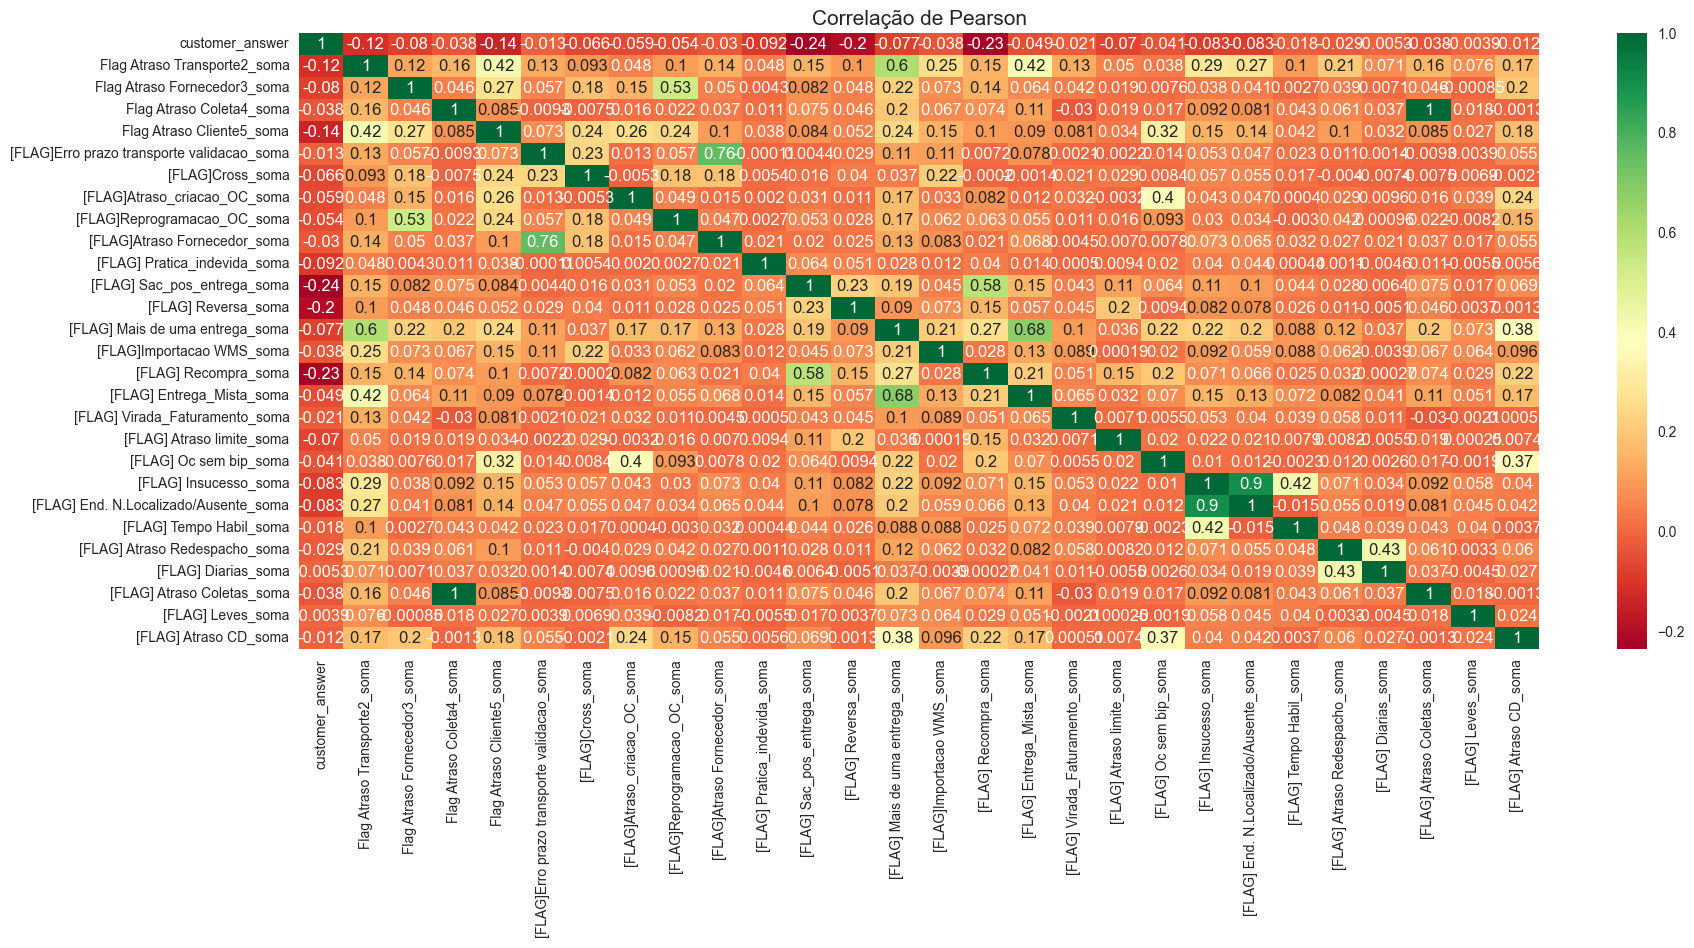

In [186]:
plt.figure(figsize=(20,8))
sns.heatmap(selecionado.corr(), annot = True, cmap= "RdYlGn");
plt.title('Correlação de Pearson',size=15);

In [187]:

# base.to_csv(r"D:\analise_corr()\analise_agora.csv", index=False)
#Variáveis independentes
x = base
#Variável dependentes
y = base['customer_answer']

modelo = LinearRegression()
modelo.fit(x, y)
LinearRegression()

LinearRegression()

In [188]:
#coeficiente de determinacao r²
modelo.score(x,y)

1.0

In [189]:
#Intercepto (ou constante) do modelo.
modelo.intercept_

7.051352390874399e-08

In [190]:
# Coeficientes (ou parâmetros) do modelo.
modelo.coef_

array([ 1.00000000e+00, -2.55287428e-15,  1.00066007e-14,  2.55880391e-14,
        3.22221123e-16, -6.49283115e-14,  3.51916482e-14, -1.39490830e-14,
        5.45829237e-14, -1.01888508e-13, -1.63170727e-14,  1.65090474e-14,
        5.72897310e-14,  8.72065978e-14, -2.13666708e-14,  1.49038582e-14,
       -2.56675941e-14,  1.61495437e-14,  1.21269628e-14,  9.35844679e-14,
       -8.03139164e-15, -3.93574633e-14, -1.63664612e-15, -4.16406114e-14,
       -1.43468171e-14, -2.19845184e-15, -1.42249414e-15, -7.75957700e-16,
       -2.15213104e-14,  2.91084267e-15,  3.22221122e-16,  3.95212121e-14,
       -1.99028601e-15, -1.43164123e-13, -1.56052346e-13,  6.44788998e-14,
       -3.03577312e-14,  6.46242517e-15,  1.66599259e-15, -4.98207479e-15])

In [191]:
# Gerando os modelos com a Pingouin
# Irei gerar dois modelos: um com intercepto e outro sem o intercepto. Porém, antes, terei que transformar as variáveis para o formato numpy.

Xp = x.to_numpy()
yp = y.to_numpy()

In [198]:
# Modelo de regressão com intercepto:
from numpy import mean
from numpy import std
from numpy import correlate
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot